In [1]:
import sys, os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from torch.autograd import Variable
from tensorflow.keras.datasets import fashion_mnist

# Load the data 

In [2]:
(trainxs, trainys), (testxs, testys) = fashion_mnist.load_data()
#train/validation/test split
input_size = testxs.shape[1] ** 2
y_train = trainys[:50000]
x_train = trainxs[:50000]
y_val = trainys[50000:]
x_val = trainxs[50000:]
x_test = testxs
y_test = testys

# Define the noise function

In [6]:
# define a noise function that removes one or two quadrants of the image
c = [0,1]
def add_noise(x):
    for k in c:
        xoffset = np.random.choice([0,14])
        yoffset = np.random.choice([0,14])
        for i in range(xoffset, xoffset+14):
            for j in range(yoffset, yoffset+14):
                x[i, j] = 0
    return x

# Create dataloaders

In this step, we create clean DataLoaders for the train, validation and test sets, add noise and then create
new noisy DataLoaders

In [8]:
#TRAIN SET :
x_clean_train = np.zeros((len(x_train),28,28))
x_noise_train = np.zeros((len(x_train),28,28))
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)
train_dataset = TensorDataset( x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset)
#add noise
i = 0
for data in tqdm(iter(train_loader)):
    x = data[0]
    x_clean_train[i] = x.numpy()
    x_noise = torch.reshape(add_noise(x[0]), (28,28))
    x_noise_train[i] = x_noise.numpy()
    i +=1
train_data = TensorDataset(torch.Tensor(x_clean_train), torch.Tensor(x_noise_train))
train_load = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True, num_workers = 4)


#VALIDATION SET :
x_clean_val = np.zeros((len(x_val),28,28))
x_noise_val = np.zeros((len(x_val),28,28))
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
val_dataset = TensorDataset( x_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset)
#add noise
i = 0
for data in tqdm(iter(val_loader)):
    x = data[0]
    x_clean_val[i] = x.numpy()
    x_noise = torch.reshape(add_noise(x[0]), (28,28))
    x_noise_val[i] = x_noise.numpy()
    i +=1
val_data = TensorDataset(torch.Tensor(x_clean_val), torch.Tensor(x_noise_val))
val_load = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle=True, num_workers = 4)


#TEST SET :
x_clean_test = np.zeros((len(x_test),28,28))
x_noise_test = np.zeros((len(x_test),28,28))
10
x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(y_test)
test_dataset = TensorDataset( x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset)
#add noise
i = 0
for data in tqdm(iter(test_loader)):
    x = data[0]
    x_clean_test[i] = x.numpy()
    x_noise = torch.reshape(add_noise(x[0]), (28,28))
    x_noise_test[i] = x_noise.numpy()
    i +=1
test_data = TensorDataset(torch.Tensor(x_clean_test), torch.Tensor(x_noise_test))
test_load = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle=True, num_workers = 4)

<ipython-input-8-f514b0d5624f>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  x_train_tensor = torch.from_numpy(x_train)


# Implement denosing autoencoder with MSE loss

The auto-encoder is a specific type of neural network with a symmetric architecture of hidden layers. It
consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the
code and the decoder reconstructs the input.

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        #step 1 : Encoder
        self.enc1 = nn.Linear(in_features = 28*28, out_features = 256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features= 64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        #step 2 : Decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=28*28)
    
    def forward(self,x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.dec5(x)) #last layer of decoder part uses sigmoid activation function
        return x

# Train the model to convergence

In [11]:
# Load the model to either cpu or gpu according to availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_network = AutoEncoder().to(device)
# Parameters
learning_rate = 0.001
epochs = 150
# Loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate)


#train the model to convergence :
losslist = []

for epoch in tqdm(range(epochs)):
    loss = 0
    for clean, noise in tqdm(train_load):
        clean = clean.view(-1,28*28).to(device)
        clean = clean/255
        noise = noise.view(-1,28*28).to(device)
        noise = noise/255
        #recontruction of images
        outputs = neural_network(noise)
        #training reconstruction loss
        train_loss = criterion(outputs, clean)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_load)
    losslist.append(loss)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("loss list :" , losslist)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



epoch : 1/150, loss = 0.048045
loss list : [0.04804488558731878]



epoch : 2/150, loss = 0.030687
loss list : [0.04804488558731878, 0.030687242127059366]



epoch : 3/150, loss = 0.028326
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504]



epoch : 4/150, loss = 0.027207
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014]



epoch : 5/150, loss = 0.026197
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578]



epoch : 6/150, loss = 0.025064
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364]



epoch : 7/150, loss = 0.024190
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037]



epoch : 8/150, loss = 0.023624
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992]



epoch : 9/150, loss = 0.023153
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637]



epoch : 10/150, loss = 0.022693
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745]



epoch : 11/150, loss = 0.022341
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831]



epoch : 12/150, loss = 0.021954
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952]



epoch : 13/150, loss = 0.021653
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386]



epoch : 14/150, loss = 0.021416
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675]



epoch : 15/150, loss = 0.021157
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272]



epoch : 16/150, loss = 0.021002
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583]



epoch : 17/150, loss = 0.020844
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238]



epoch : 18/150, loss = 0.020637
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754]



epoch : 19/150, loss = 0.020511
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995]



epoch : 20/150, loss = 0.020337
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235]



epoch : 21/150, loss = 0.020222
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138]



epoch : 22/150, loss = 0.020074
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094]



epoch : 23/150, loss = 0.019989
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154]



epoch : 24/150, loss = 0.019879
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936]



epoch : 25/150, loss = 0.019749
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608]



epoch : 26/150, loss = 0.019671
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195]



epoch : 27/150, loss = 0.019545
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808]



epoch : 28/150, loss = 0.019445
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954]



epoch : 29/150, loss = 0.019378
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459]



epoch : 30/150, loss = 0.019244
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383]



epoch : 31/150, loss = 0.019150
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946]



epoch : 32/150, loss = 0.019032
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506]



epoch : 33/150, loss = 0.018880
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304]



epoch : 34/150, loss = 0.018829
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653]



epoch : 35/150, loss = 0.018656
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877]



epoch : 36/150, loss = 0.018619
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158]



epoch : 37/150, loss = 0.018484
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156]



epoch : 38/150, loss = 0.018402
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465]



epoch : 39/150, loss = 0.018325
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489]



epoch : 40/150, loss = 0.018255
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133]



epoch : 41/150, loss = 0.018168
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363]



epoch : 42/150, loss = 0.018129
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904]



epoch : 43/150, loss = 0.018012
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078]



epoch : 44/150, loss = 0.017976
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396]



epoch : 45/150, loss = 0.017933
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 46/150, loss = 0.017848
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 47/150, loss = 0.017784
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 48/150, loss = 0.017752
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 49/150, loss = 0.017703
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 50/150, loss = 0.017661
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 51/150, loss = 0.017596
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 52/150, loss = 0.017581
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 53/150, loss = 0.017510
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 54/150, loss = 0.017447
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 55/150, loss = 0.017393
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 56/150, loss = 0.017360
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 57/150, loss = 0.017335
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 58/150, loss = 0.017262
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 59/150, loss = 0.017199
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 60/150, loss = 0.017166
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 61/150, loss = 0.017111
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 62/150, loss = 0.017058
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 63/150, loss = 0.017007
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 64/150, loss = 0.016993
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 65/150, loss = 0.016907
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 66/150, loss = 0.016841
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 67/150, loss = 0.016871
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 68/150, loss = 0.016758
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 69/150, loss = 0.016758
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 70/150, loss = 0.016704
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 71/150, loss = 0.016642
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 72/150, loss = 0.016657
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 73/150, loss = 0.016556
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 74/150, loss = 0.016551
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 75/150, loss = 0.016500
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 76/150, loss = 0.016440
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 77/150, loss = 0.016443
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 78/150, loss = 0.016439
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 79/150, loss = 0.016347
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 80/150, loss = 0.016348
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 81/150, loss = 0.016293
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 82/150, loss = 0.016342
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 83/150, loss = 0.016223
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 84/150, loss = 0.016218
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 85/150, loss = 0.016263
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 86/150, loss = 0.016152
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 87/150, loss = 0.016141
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 88/150, loss = 0.016109
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 89/150, loss = 0.016094
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 90/150, loss = 0.016057
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 91/150, loss = 0.016022
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 92/150, loss = 0.016052
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 93/150, loss = 0.015990
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 94/150, loss = 0.015938
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 95/150, loss = 0.015954
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 96/150, loss = 0.015895
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 97/150, loss = 0.015900
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 98/150, loss = 0.015859
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 99/150, loss = 0.015877
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.0179334


epoch : 100/150, loss = 0.015799
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 101/150, loss = 0.015755
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 102/150, loss = 0.015749
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 103/150, loss = 0.015734
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 104/150, loss = 0.015697
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 105/150, loss = 0.015721
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 106/150, loss = 0.015655
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 107/150, loss = 0.015643
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 108/150, loss = 0.015597
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 109/150, loss = 0.015601
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 110/150, loss = 0.015602
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 111/150, loss = 0.015586
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 112/150, loss = 0.015575
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 113/150, loss = 0.015536
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 114/150, loss = 0.015519
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 115/150, loss = 0.015461
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 116/150, loss = 0.015458
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 117/150, loss = 0.015438
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 118/150, loss = 0.015406
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 119/150, loss = 0.015425
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 120/150, loss = 0.015368
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 121/150, loss = 0.015392
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 122/150, loss = 0.015370
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 123/150, loss = 0.015349
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 124/150, loss = 0.015306
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 125/150, loss = 0.015339
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 126/150, loss = 0.015301
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 127/150, loss = 0.015299
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 128/150, loss = 0.015241
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 129/150, loss = 0.015265
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 130/150, loss = 0.015195
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 131/150, loss = 0.015228
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 132/150, loss = 0.015202
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 133/150, loss = 0.015184
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 134/150, loss = 0.015208
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 135/150, loss = 0.015177
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 136/150, loss = 0.015181
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 137/150, loss = 0.015111
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 138/150, loss = 0.015132
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 139/150, loss = 0.015124
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 140/150, loss = 0.015108
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 141/150, loss = 0.015080
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 142/150, loss = 0.015074
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 143/150, loss = 0.015039
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 144/150, loss = 0.015061
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 145/150, loss = 0.015022
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 146/150, loss = 0.015025
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 147/150, loss = 0.015054
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 148/150, loss = 0.014993
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 149/150, loss = 0.015008
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933


epoch : 150/150, loss = 0.015016
loss list : [0.04804488558731878, 0.030687242127059366, 0.028325845446923504, 0.02720706879883014, 0.026197104626680578, 0.02506364527089364, 0.02418971135069037, 0.023623952858835992, 0.02315334045349637, 0.022692977669922745, 0.0223407316309831, 0.021953678999543952, 0.02165310765328386, 0.021416172623405675, 0.02115680442532272, 0.02100152473496583, 0.02084396844801238, 0.020636780042191754, 0.02051124759995, 0.020336717957883235, 0.02022155877941138, 0.020074059445973094, 0.019988947690886154, 0.019879242368375936, 0.019749382172551608, 0.019670612006055195, 0.019544808889555808, 0.019445481379051954, 0.01937830664903459, 0.01924366190972383, 0.019150482391809946, 0.019032190895646506, 0.01888003138482304, 0.018828929815193653, 0.01865616335254877, 0.018618830723826158, 0.01848372513109156, 0.01840241544920465, 0.01832478072570489, 0.018254614250539133, 0.018168394033418363, 0.018128619056499904, 0.018011601644156078, 0.017976157841227396, 0.017933

# Plot loss on the training set and validation set for each epoch of training

In [ ]:
losslist_val = []

for epoch in range(epochs):
    loss = 0
    for clean, noise in val_load:
        clean = clean.view(-1,28*28).to(device)
        clean = clean/255
        noise = noise.view(-1,28*28).to(device)
        noise = noise/255
        outputs = neural_network(noise)
        val_loss = criterion(outputs, clean)
        optimizer.zero_grad()
        val_loss.backward()
        optimizer.step()
        loss += val_loss.item()
    loss = loss / len(val_load)
    losslist_val.append(loss)
    
plt.plot(range(len(losslist)),losslist, label= "Training loss")
plt.plot(range(len(losslist_val)),losslist_val, label ="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

# Plot the first image in its original, “noisy”, and “denoised” form from train set 

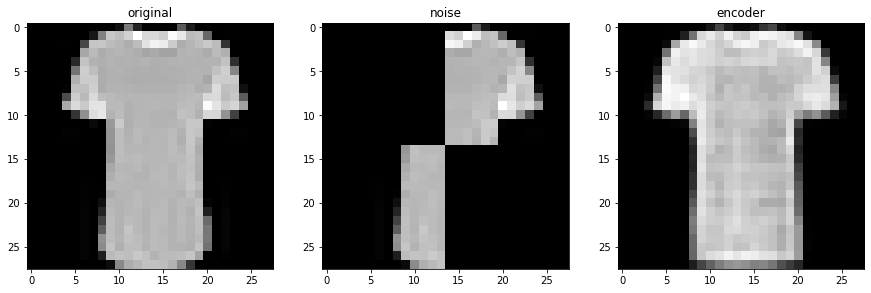

In [17]:
for clean, noise in tqdm(train_load):
    _, plots = plt.subplots(1,3, figsize =(15,15))
    plots[0].set_title('original')
    plots[1].set_title('noise')
    plots[2].set_title('encoder')
    plots[0].imshow(clean[0].view(28,28), cmap = 'gray')
    plots[1].imshow(noise[0].view(28,28), cmap = 'gray')

    noise = noise[0].view(-1, 28*28).to(device)
    noise = noise/255

    encoder_image = neural_network(noise)
    encoder_image = encoder_image.view(1, 28, 28)
    encoder_image = encoder_image.detach().cpu().numpy()

    plots[2].imshow(encoder_image[0], cmap = 'gray')

    break

# Plot the first image in its original, “noisy”, and “denoised” form from val set 

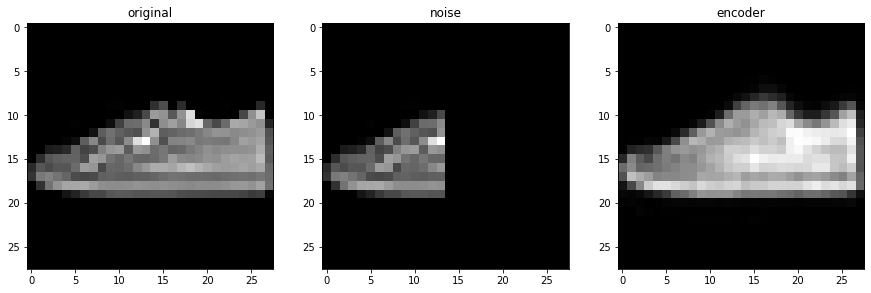

In [18]:
for clean, noise in tqdm(val_load):
    _, plots = plt.subplots(1,3, figsize =(15,15))
    plots[0].set_title('original')
    plots[1].set_title('noise')
    plots[2].set_title('encoder')
    plots[0].imshow(clean[0].view(28,28), cmap = 'gray')
    plots[1].imshow(noise[0].view(28,28), cmap = 'gray')

    noise = noise[0].view(-1, 28*28).to(device)
    noise = noise/255

    encoder_image = neural_network(noise)
    encoder_image = encoder_image.view(1, 28, 28)
    encoder_image = encoder_image.detach().cpu().numpy()

    plots[2].imshow(encoder_image[0], cmap = 'gray')

    break

Remark : By plotting more images, we can notice that the denoising autoencoder works well in general.  Nonetheless, it recognizes certain classes more easily than others.  Without loss of generality, we observe that shoes, shirts and trousers are well reconstructed.  Whilst, bags are often reconstructed as shoes or as undefined items. The autoencoder reconstructs the image pixel by pixel with value from 0 (black) to 255 (white). Thus, one could say that two images reconstructed similarly have similar intensity value distribution of pixel. Therefore, we assume that shoes and bags images have similar intensity value distributions of pixels, whilst, for shirt and trousers images the distribution is distinct.